# Imports

In [150]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Configs

In [151]:
LABELED_PATH = 'data/labels.parquet'

# Load Data

In [ ]:
dataset = pd.read_parquet(LABELED_PATH)
print(dataset.shape)
dataset.head()


# Evaluation

In [258]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = labeled_df.groupby('Location')['Demand'].sum().reset_index().sort_values(by='Demand', ascending=False).reset_index()
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()

    plt.plot(range(1,263), cumulative_demand)
    plt.xlabel('Location numbers')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')

    plt.legend() 
    plt.show()
    important_locations = grouped_df.iloc[:target_x, grouped_df.columns.get_loc('Location')]
    important_locations = important_locations.to_numpy()
    return important_locations

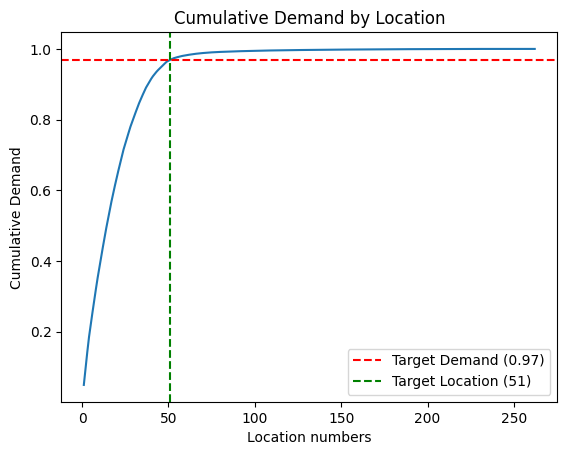

In [264]:
important_locations = plot_cumsum_demand(labeled_df, 0.97)

In [171]:
def evaluate(metric, metric_name, df_true, df_pred, important_locations):
    selected_df_true = df_true[df_true['Location'].isin(important_locations)]['Demand'].to_numpy()
    selected_df_pred = df_pred[df_pred['Location'].isin(important_locations)]['Predicted_demand'].to_numpy()

    print(f'{metric_name} : {metric(selected_df_true, selected_df_pred)}')

In [172]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [173]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df, important_locations):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df, train_prediction_df, important_locations)
    evaluate(mean_squared_error, 'MSE', train_df, train_prediction_df, important_locations)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df, train_prediction_df, important_locations)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df, test_prediction_df, important_locations)
    evaluate(mean_squared_error, 'MSE', test_df, test_prediction_df, important_locations)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df, test_prediction_df, important_locations)


In [ ]:
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)

In [265]:
evaluation('XGB', train_df, test_df, labeled_train_prediction_df, labeled_test_prediction_df, important_locations)

XGB train scores:
MAE : 110.06324682634491
MSE : 25272.586949349374
MAPE : 0.07305495153530532
XGB test scores:
MAE : 181.91819887846904
MSE : 72357.98442947163
MAPE : 0.0968357562781373


### Visualization

In [176]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [177]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df, important_locations):

    train_data = train_data[train_data['Location'].isin(important_locations)]
    test_data = test_data[test_data['Location'].isin(important_locations)]

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = add_day_of_year(train_prediction_df)
    predicted_test_df = add_day_of_year(test_prediction_df)

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted_demand'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted_demand'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Train actual Value", "Predicted"], loc ="lower right")
    plt.show()

    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Test actual Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


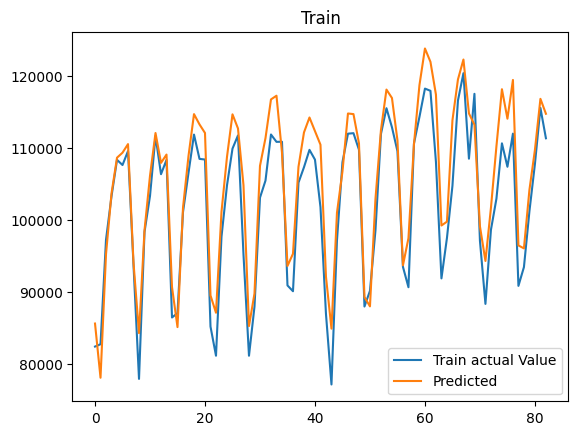

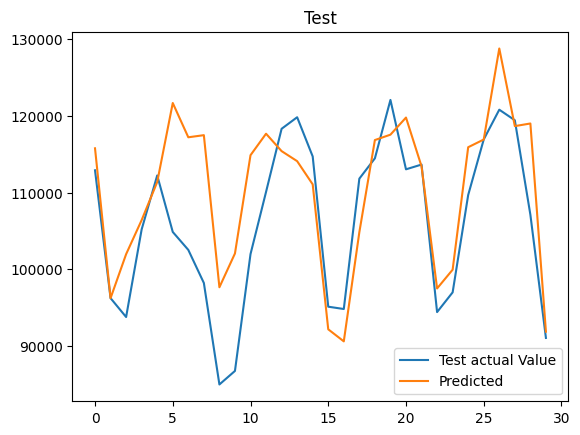

In [186]:
prediction_visualization(train_df, test_df, labeled_train_prediction_df, labeled_test_prediction_df, important_locations)

In [221]:
def prediction_visualization_for_location(train_df, test_df, train_prediction_df, test_prediction_df, important_locations):

    train_df = add_day_of_year(train_df)
    test_df = add_day_of_year(test_df)

    fig, axes = plt.subplots(nrows=len(important_locations) // 2 + 1, ncols=2, figsize=(10,100))
    for i, ax in enumerate(axes.flat):
        try:
            important_location = important_locations[i]
        except IndexError:
            continue
        location_train_df = train_df[train_df['Location'] == important_location]
        location_train_df_pred = train_prediction_df[train_prediction_df['Location'] == important_location]

        location_train_df = location_train_df.groupby('day_year')['Demand'].sum()
        location_train_df_pred = location_train_df_pred.groupby('day_year')['Predicted_demand'].sum()

        ax.plot(location_train_df, label = 'Train actual')
        ax.plot(location_train_df_pred, label = 'Train predicted')
        ax.set_title('Location ' + str(important_locations[i]))
        ax.legend()
    plt.show()


    fig, axes = plt.subplots(nrows=len(important_locations) // 2 + 1, ncols=2, figsize=(10,100))
    for i, ax in enumerate(axes.flat):
        try:
            important_location = important_locations[i]
        except IndexError:
            continue
        location_test_df = test_df[test_df['Location'] == important_location]
        location_test_df_pred = test_prediction_df[test_prediction_df['Location'] == important_location]

        location_test_df = location_test_df.groupby('day_year')['Demand'].sum()
        location_test_df_pred = location_test_df_pred.groupby('day_year')['Predicted_demand'].sum()

        ax.plot(location_test_df, label = 'Test actual')
        ax.plot(location_test_df_pred, label = 'Test predicted')
        ax.set_title('Location ' + str(important_locations[i]))
        ax.legend()
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


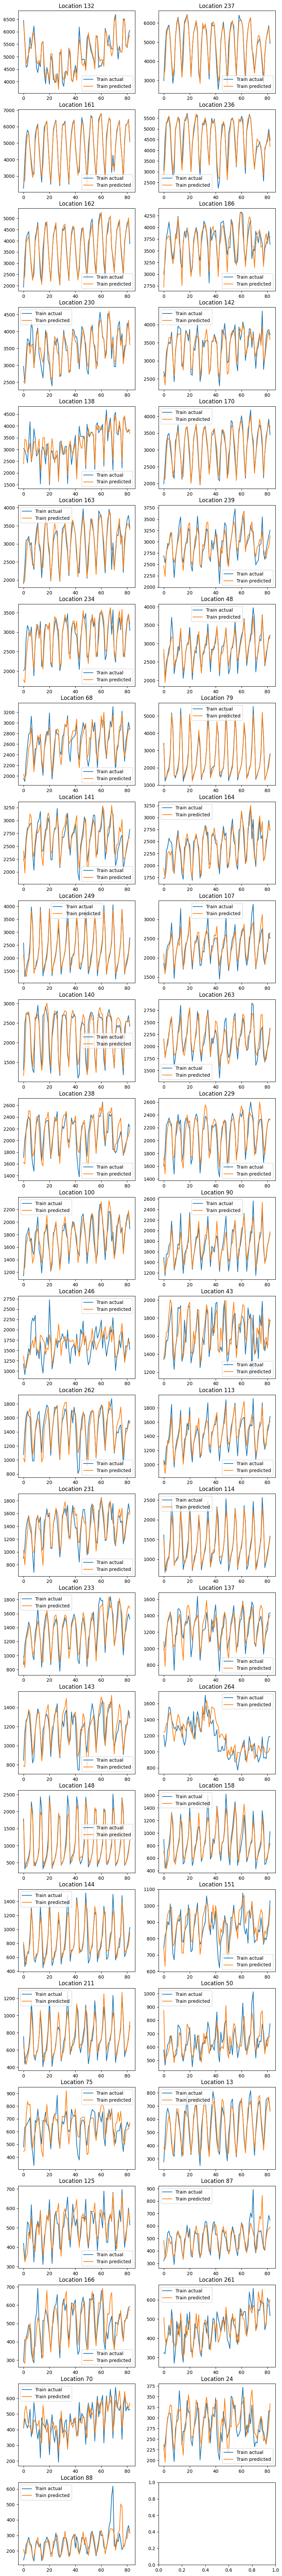

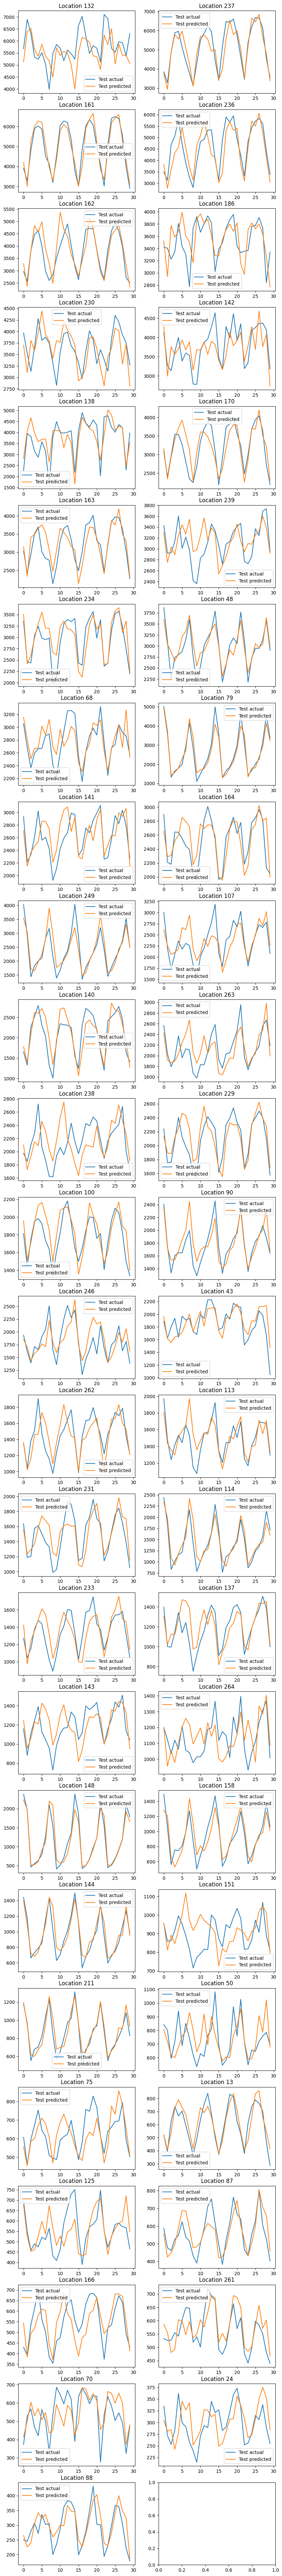

In [231]:
prediction_visualization_for_location(train_df, test_df, labeled_train_prediction_df, labeled_test_prediction_df, important_locations)

### Feature Importance and SHAPE

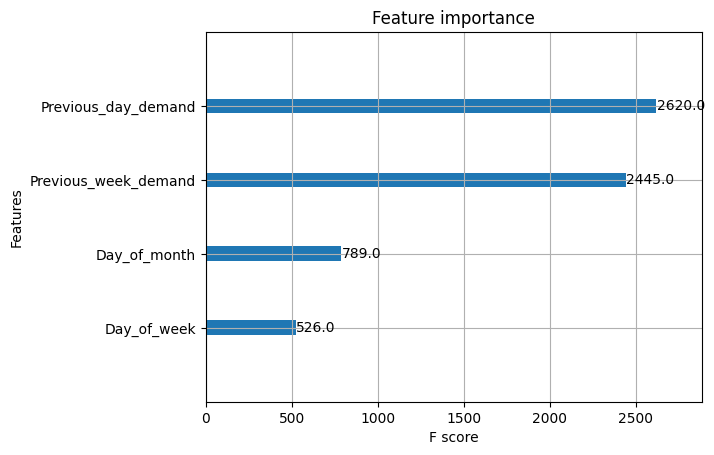

In [ ]:
xgb.plot_importance(model)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


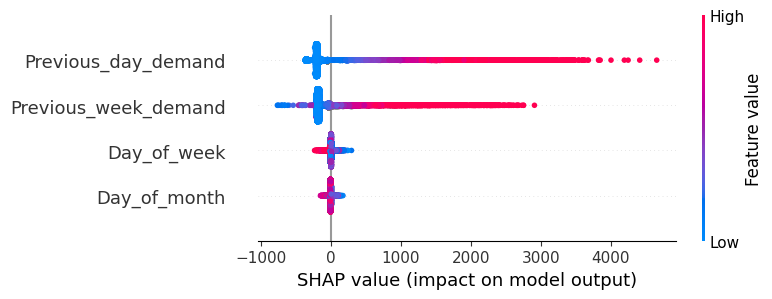

In [ ]:
dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])

# File Saving

In [ ]:
def save_predictions(dataset, path):
    output_df = dataset[['Location', 'Date', 'Predicted_demand']]
    output_df.to_parquet(path, index=False)
    return output_df

In [ ]:
output_df = save_predictions(labeled_test_prediction_df, OUTPUT_PATH)
print(f'output_df shape : {output_df.shape}')
output_df.head()

output_df shape : (7860, 3)


Location       Date  Predicted_demand
0         1 2023-04-01         18.244568
1         1 2023-04-02         10.477506
2         1 2023-04-03         10.072111
3         1 2023-04-04         12.195824
4         1 2023-04-05          6.412234